Enter the path to the CSV file: wfpvam_foodprices.csv
Enter the adm0_name: Afghanistan
Enter the cm_name: Wheat - Retail


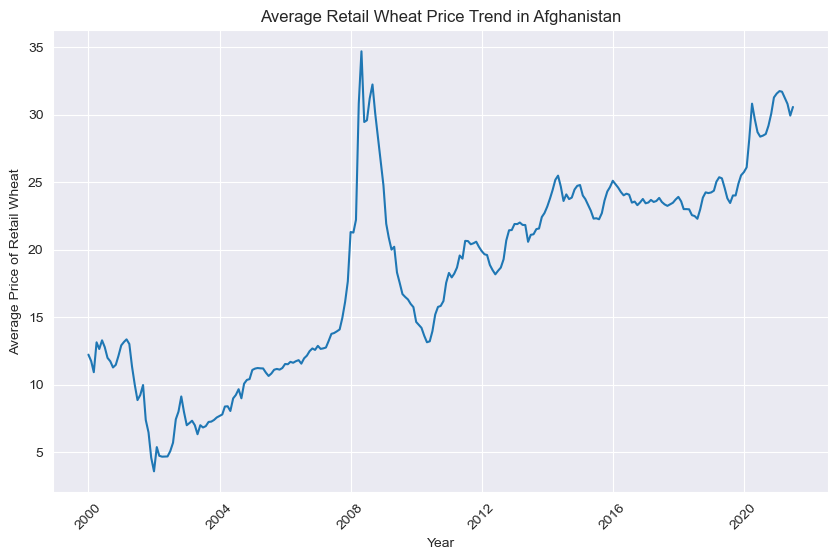

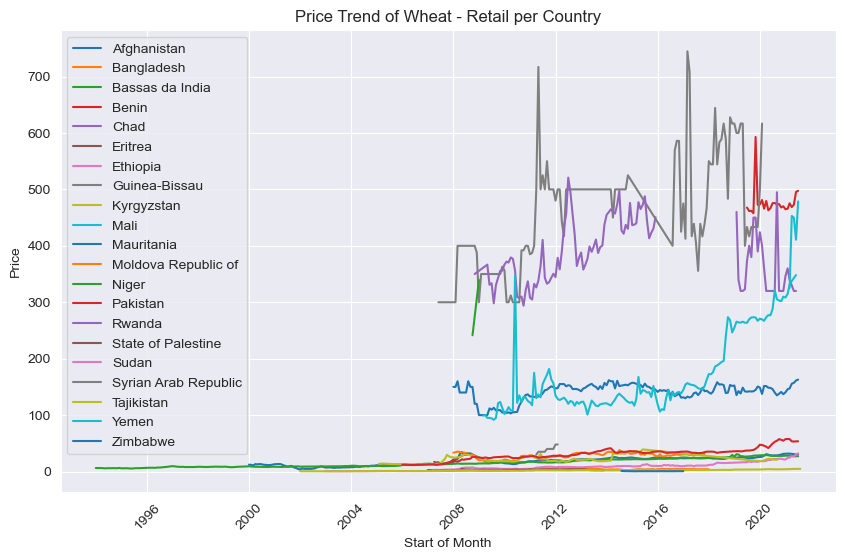

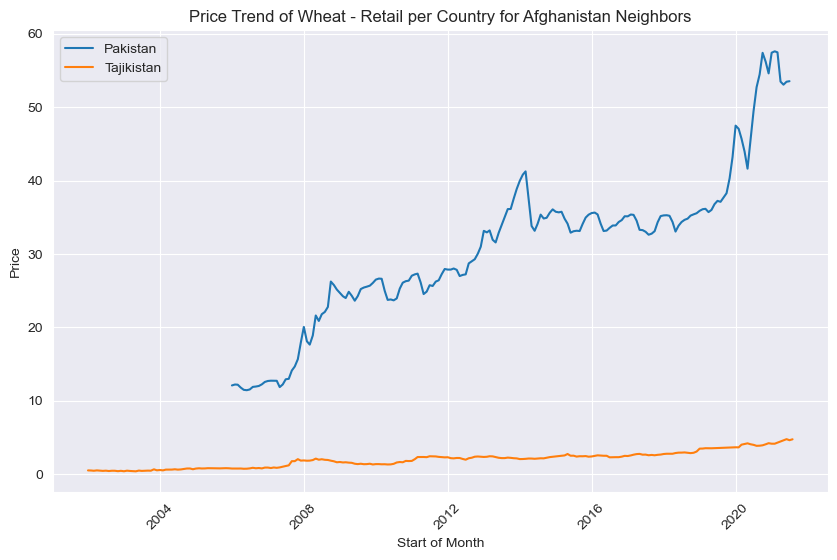

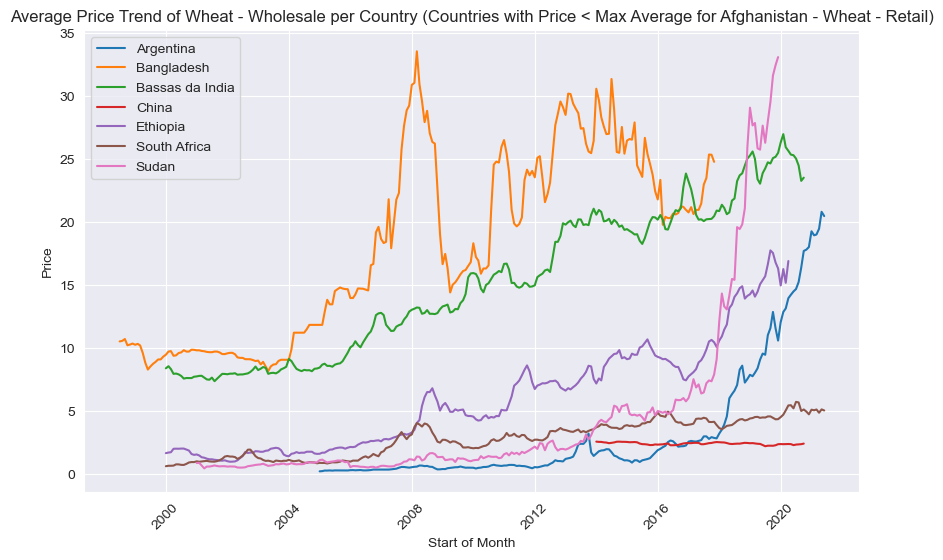

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pandas.api.types import CategoricalDtype
import warnings
import geopandas as gpd
from countryinfo import CountryInfo
import pycountry

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

# Manually define country aliases
country_aliases = {
    'Bassas da India': ['France'],
    'State of Palestine': ['Palestine'],
    'Syrian Arab Republic': ['Syria'],
}

# Function to add date column as start of month
def add_start_of_month(df):
    df['mp_month'] = df['mp_month'].astype(str).str.zfill(2)
    df['mp_year'] = df['mp_year'].astype(str).str.zfill(2)
    df['start_of_month'] = pd.to_datetime(df['mp_month'] + df['mp_year'], format='%m%Y')
    df['start_of_month'] = df['start_of_month'].dt.to_period('M').dt.to_timestamp()
    return df

# Function to separate quantity and metric before standardizing
def separate_quantity_metric(df):
    um_quantity = []
    um_metric = []

    for value in df.um_name:
        quantity = re.findall(r'\d+(?:\.\d+)?', value)
        if quantity:
            um_quantity.append(float(quantity[0]))
        else:
            um_quantity.append(1)

        metric = re.sub(r'\d+(?:\.\d+)?', '', value).strip()
        um_metric.append(metric)

    df['um_quantity'] = um_quantity
    df['um_metric'] = um_metric
    return df

# Function to standardize quantity
def standardize_quantity(df):
    df['updated_quantity'] = np.where(df.um_metric.isin(['g', 'G']), df.um_quantity / 1000, df.um_quantity)
    df['updated_quantity'] = np.where(df.um_metric.isin(['ml', 'ML']), df.um_quantity / 1000, df.um_quantity)
    df['updated_metric'] = np.where(df.um_metric.isin(['g', 'G']), 'KG',
                                    np.where(df.um_metric.isin(['ml', 'ML']), 'L', df.um_metric))
    return df

# Function to calculate price per unit/metric
def calculate_price_per_unit(df):
    df['mp_price_pu'] = df['mp_price'] / df['updated_quantity']
    return df

# Function to get country name from country code
def get_country_name(country_code):
    try:
        country = pycountry.countries.get(alpha_3=country_code)
        if country:
            return country.name
        else:
            return None
    except AttributeError:
        return None

# Function to get bordering countries for a given country
def get_bordering_countries(target_country):
    bordering_countries = set()

    try:
        if target_country in country_aliases:
            aliases = country_aliases[target_country]
            for alias in aliases:
                country_info = CountryInfo(alias)
                bordering_countries.update(country_info.borders())
        else:
            country_info = CountryInfo(target_country)
            bordering_countries.update(country_info.borders())
    except KeyError:
        print(f"Could not find country: {target_country}")

    country_names = [get_country_name(country_code) for country_code in bordering_countries]
    return [name for name in country_names if name is not None]

# Function to plot average wheat prices in a specific country
def plot_avg_wheat_prices(df, adm0_name):
    df_avg_price = df.groupby('start_of_month')['mp_price_pu'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(df_avg_price['start_of_month'], df_avg_price['mp_price_pu'])
    plt.xlabel('Year')
    plt.ylabel('Average Price of Retail Wheat')
    plt.title(f'Average Retail Wheat Price Trend in {adm0_name}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig(f'Average_Retail_Wheat_Price_Trend_in_{adm0_name}.png')
    plt.show()

# Function to plot price trend of a commodity in all countries
def plot_price_trend_all_countries(df, cm_name):
    df_cm = df[df['cm_name'] == cm_name]
    df_avg = df_cm.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

    plt.figure(figsize=(10, 6))

    countries = df_avg['adm0_name'].unique()
    for country in countries:
        country_df = df_avg[df_avg['adm0_name'] == country]
        plt.plot(country_df['start_of_month'], country_df['mp_price_pu'], label=country)

    plt.xlabel('Start of Month')
    plt.ylabel('Price')
    plt.title(f'Price Trend of {cm_name} per Country')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig(f'Price_Trend_of_{cm_name}_per_Country.png')
    plt.show()

# Function to plot price trend of a commodity in neighboring countries
def plot_price_trend_neighboring_countries(df, adm0_name, cm_name):
    bordering_countries = get_bordering_countries(adm0_name)
    df_cm_nbr = df[(df['cm_name'] == cm_name) & df['adm0_name'].isin(bordering_countries)]
    df_avg_nbr = df_cm_nbr.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

    plt.figure(figsize=(10, 6))

    countries = df_avg_nbr['adm0_name'].unique()
    for country in countries:
        country_df = df_avg_nbr[df_avg_nbr['adm0_name'] == country]
        plt.plot(country_df['start_of_month'], country_df['mp_price_pu'], label=country)

    plt.xlabel('Start of Month')
    plt.ylabel('Price')
    plt.title(f'Price Trend of {cm_name} per Country for {adm0_name} Neighbors')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig(f'Price_Trend_of_{cm_name}_per_Country_for_{adm0_name}_Neighbors.png')
    plt.show()



# Function to get the alternate commodity name
def get_alternate_commodity(cm_name):
    if 'Retail' in cm_name:
        return cm_name.replace('Retail', 'Wholesale')
    elif 'Wholesale' in cm_name:
        return cm_name.replace('Wholesale', 'Retail')
    else:
        print(f"Alternate commodity not available for {cm_name}")
        return None

# Function to plot average price trend of an alternate commodity per country
def plot_avg_price_trend_alt_commodity(df, adm0_name, cm_name):
    alt_commodity = get_alternate_commodity(cm_name)
    if alt_commodity is None:
        return

    df_alt_commodity = df[df['cm_name'] == alt_commodity]
    df_avg_alt_commodity = df_alt_commodity.groupby(['adm0_name', 'start_of_month'])['mp_price_pu'].mean().reset_index()

    # Calculate the mean average mp_price_pu for the specified adm0_name and cm_name
    df_avg_cm = df[(df['cm_name'] == cm_name) & (df['adm0_name'] == adm0_name)].groupby('start_of_month')['mp_price_pu'].mean().reset_index()
    max_avg_price_adm0_cm = df_avg_cm['mp_price_pu'].max()

    # Filter the countries where their most recent average price is less than the maximum average for the specified adm0_name and cm_name
    df_avg_alt_commodity = df_avg_alt_commodity[df_avg_alt_commodity['mp_price_pu'] < max_avg_price_adm0_cm]

    if df_avg_alt_commodity.empty:
        print(f"No data available for {alt_commodity} in countries with price less than mean average for {adm0_name}.")
        return

    plt.figure(figsize=(10, 6))

    for country in df_avg_alt_commodity['adm0_name'].unique():
        country_df = df_avg_alt_commodity[df_avg_alt_commodity['adm0_name'] == country]
        plt.plot(country_df['start_of_month'], country_df['mp_price_pu'], label=country)

    plt.xlabel('Start of Month')
    plt.ylabel('Price')
    plt.title(f'Average Price Trend of {alt_commodity} per Country (Countries with Price < Max Average for {adm0_name} - {cm_name})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


# Main data processing and plotting pipeline
def data_pipeline():
    filepath = input("Enter the path to the CSV file: ")
    df = pd.read_csv(filepath)

    adm0_name = input("Enter the adm0_name: ")
    cm_name = input("Enter the cm_name: ")

    # Data processing steps
    df = add_start_of_month(df)
    df = separate_quantity_metric(df)
    df = standardize_quantity(df)
    df = calculate_price_per_unit(df)

    df_afn_wheat = df[(df['adm0_name'] == adm0_name) & (df['cm_name'] == cm_name)]

    # Plotting steps
    plot_avg_wheat_prices(df_afn_wheat, adm0_name)
    plot_price_trend_all_countries(df, cm_name)
    plot_price_trend_neighboring_countries(df, adm0_name, cm_name)
    plot_avg_price_trend_alt_commodity(df, adm0_name, cm_name)  # Add adm0_name as argument



# Call the data pipeline function
data_pipeline()
